## dotplot

In [ ]:
import os
import pandas as pd
import scanpy as sc

patient_id = "P1CRC"
data_type = "HD"

raw_data_path = "/home/wys/Sim2Real-ST/REVISE_data_process/raw_data"
svc_data_path = "../REVISE/results/HD"

raw_file_name = f"{raw_data_path}/{patient_id}_{data_type}.h5ad"
sp_SVC_file_name = f"{svc_data_path}/{patient_id}/{patient_id}_{data_type}_pot_REVISE.h5ad"
adata_sp = sc.read_h5ad(raw_file_name)
adata_sp_svc = sc.read_h5ad(sp_SVC_file_name)
adata_sp_svc.X = adata_sp_svc.layers["ot_smooth"]
del adata_sp_svc.layers


In [ ]:
def get_degs(adata, groupby, method='t-test', marker_gene_num = 10):
    adata = adata.copy()
    adata.obs[groupby] = adata.obs[groupby].astype('category')
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

    # sc.pp.highly_variable_genes(adata, n_top_genes=3000)
    # adata = adata[:, adata.var['highly_variable']]
    # sc.pp.scale(adata)
    
    print("Conducting differential expression analysis...")
    sc.tl.rank_genes_groups(adata, 
        groupby=groupby, method=method, use_raw=False)

    rank_genes_groups_df = pd.DataFrame()
    all_marker_genes = []
    for group in adata.obs[groupby].cat.categories:
        marker_gene = adata.uns['rank_genes_groups']['names'][group][:marker_gene_num]
        all_marker_genes.extend(marker_gene)
        # 提取每个组的差异基因和统计值
        group_df = pd.DataFrame({
            'group': group,
            'gene': adata.uns['rank_genes_groups']['names'][group],
            'logfoldchanges': adata.uns['rank_genes_groups']['logfoldchanges'][group],
            'pvals': adata.uns['rank_genes_groups']['pvals'][group],
            'pvals_adj': adata.uns['rank_genes_groups']['pvals_adj'][group]
        })
        group_df = group_df[group_df['logfoldchanges'] > 2]
        rank_genes_groups_df = pd.concat([rank_genes_groups_df, group_df])

    # 重置索引
    rank_genes_groups_df['log_q'] = -np.log10(rank_genes_groups_df['pvals_adj']+1e-100)
    rank_genes_groups_df.sort_values(by = "log_q", ascending = False, inplace = True)
    rank_genes_groups_df.reset_index(drop=True, inplace=True)

    return rank_genes_groups_df, all_marker_genes




marker_genes_dict = {
    "B-cell": ["CD79A", "MS4A1"],
    "Dendritic": ["FCER1A", "CST3"],
    "Monocytes": ["FCGR3A"],
    "NK": ["GNLY", "NKG7"],
    "Other": ["IGLL1"],
    "T-cell": ["CD3D"],
}

sc.pl.dotplot(adata, marker_genes_dict, groupby, dendrogram=True)

In [14]:
import os
import pandas as pd
import scanpy as sc
import numpy as np
from matplotlib import pyplot as plt

patient_id = "P1CRC"
data_type = "HD"

raw_data_path = "/home/wys/Sim2Real-ST/REVISE_data_process/raw_data"
svc_data_path = "../REVISE/results/HD"

raw_file_name = f"{raw_data_path}/{patient_id}_{data_type}.h5ad"
sp_SVC_file_name = f"{svc_data_path}/{patient_id}/{patient_id}_{data_type}_pot_REVISE.h5ad"
adata_sp = sc.read_h5ad(raw_file_name)
adata_sp_svc = sc.read_h5ad(sp_SVC_file_name)
adata_sp_svc.X = adata_sp_svc.layers["ot_smooth"]
del adata_sp_svc.layers
# adata_sp_svc.X = np.round(adata_sp_svc.X)


In [15]:
adata_sp_svc.X.data[adata_sp_svc.X.data < 0.2] = 0

In [16]:
from spatial_metric import get_sampeled_adata

adata_sp = get_sampeled_adata(adata_sp, sample_size = 30000, seed = 42)
adata_sp_svc = get_sampeled_adata(adata_sp_svc, sample_size = 30000, seed = 42)

Sampling 30000 cells from 507684 total cells.
Sampling 30000 cells from 430168 total cells.


In [ ]:
gene_list = [
    # T cells
    "CD3D", "CD3E", "CD2", "TRAC", "TRBC1", "CD4", "CD8A", "CD8B", "IL7R",
    # B cells
    "MS4A1", "CD19", "CD79A", "CD79B", "PAX5",
    # Plasma cells
    "MZB1", "JCHAIN", "XBP1", "PRDM1", "IGKC",
    # NK cells
    "KLRD1", "NKG7", "GNLY", "PRF1", "GZMB", "GZMA",
    # Monocytes
    "CD14", "FCGR3A", "S100A8", "S100A9", "LYZ",
    # Macrophages
    "CD68", "CD163", "MARCO", "MRC1", "MSR1",
    # Dendritic cells
    "CLEC9A", "ITGAX", "CD1C", "LAMP3", "IRF8",
    # Mast cells
    "TPSAB1", "TPSB2", "KIT", "CMA1",
    # Vascular endothelial
    "PECAM1", "VWF", "CDH5", "KDR", "CLDN5",
    # Lymphatic endothelial
    "PROX1", "LYVE1", "PDPN", "FLT4",
    # Fibroblasts
    "COL1A1", "COL1A2", "COL3A1", "DCN", "LUM", "FAP", "PDGFRA",
    # Pericytes
    "RGS5", "PDGFRB", "CSPG4", "ACTA2",
    # Smooth muscle cells
    "ACTA2", "TAGLN", "MYH11", "CNN1",
    # Intestinal epithelial
    "EPCAM", "KRT19", "KRT8", "MUC2", "TFF3", "CDH1",
    # Tumor cells (general)
    "EPCAM", "KRT18", "KRT8", "MKI67", "SOX2"
]

# degs_merge = degs_merge[degs_merge['gene'].isin(gene_list) ]
# degs_merge.sort_values(by=['cell_type','ratio'], ascending=False, inplace=True)
# degs_merge


In [ ]:
# degs_merge[['ratio','cell_type','gene']].to_csv("a.csv")
selected_marker_genes = {
    'T': ["CD3D", "CD3E", "CD2", "TRAC", "TRBC1", "CD4", "CD8A", "CD8B", "IL7R", "TNFRSF1A"],
    'B': ["MS4A1", "CD19", "CD79A", "CD79B", "PAX5"],
    'NK': ["GNLY", "NKG7", "KLRB1", "FCGR3A", "CD56"],
    'Plasma': ["KIT"],
}


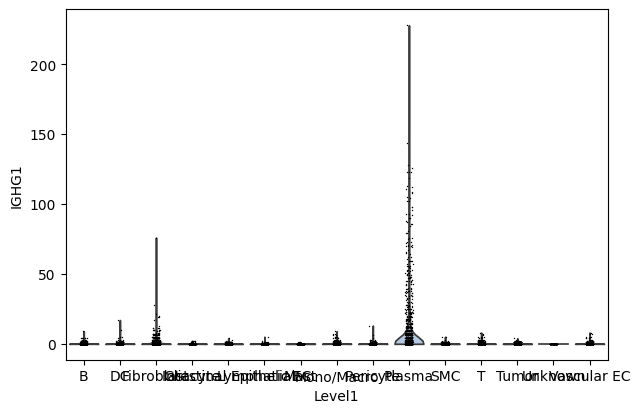

In [11]:
sc.pl.violin(adata_sp,['IGHG1'],groupby='Level1')

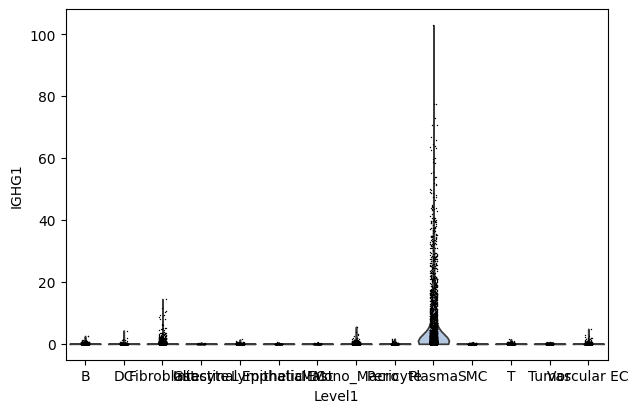

In [17]:
sc.pl.violin(adata_sp_svc,['IGHG1'],groupby='Level1')

In [23]:
selected_marker_genes = {
    'T': ["CD3D", "CD3E", "CD2", "TRAC", "CD4", "CD8A", "IL7R", "TNFRSF1A"],
    'B': ["MS4A1", "CD19", "CD79A", "CD79B", "PAX5"],
    'Plasma': ["MZB1", "JCHAIN", "XBP1", "PRDM1", "IGKC"],
    'NK': ["GNLY", "NKG7", "KLRB1", "FCGR3A"],
    'Monocytes': ["CD14", "FCGR3A", "S100A8", "S100A9", "LYZ"],
    'Dendritic': ["CLEC9A", "ITGAX", "CD1C", "LAMP3", "IRF8"],
    'Mast': ["KIT",],
}


categories: B, DC, Fibroblast, etc.
var_group_labels: T, B, Plasma, etc.
categories: B, DC, Fibroblast, etc.
var_group_labels: T, B, Plasma, etc.


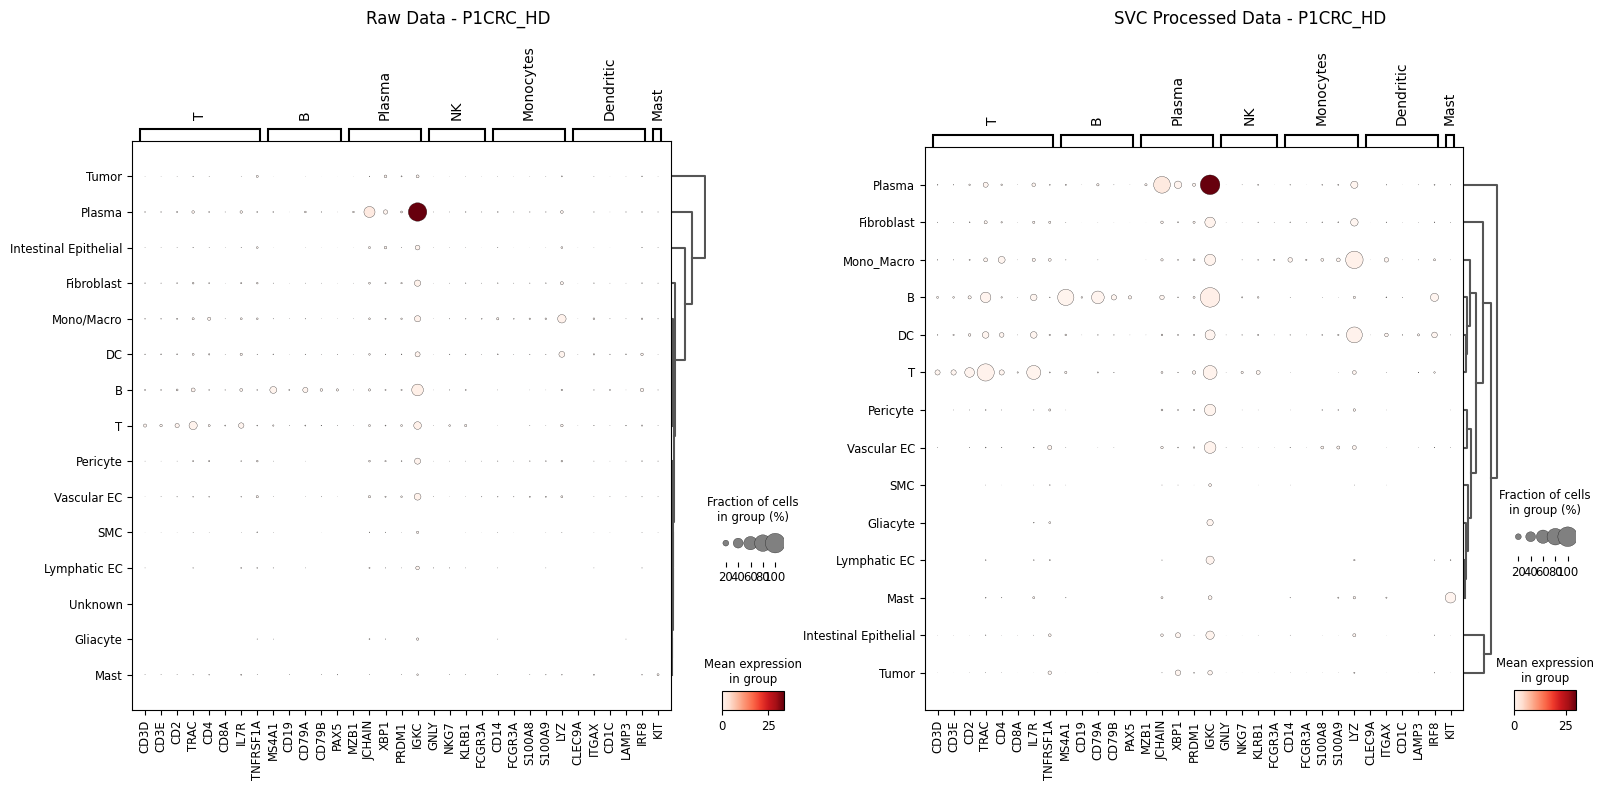

Raw data dotplot:
categories: B, DC, Fibroblast, etc.
var_group_labels: T, B, Plasma, etc.


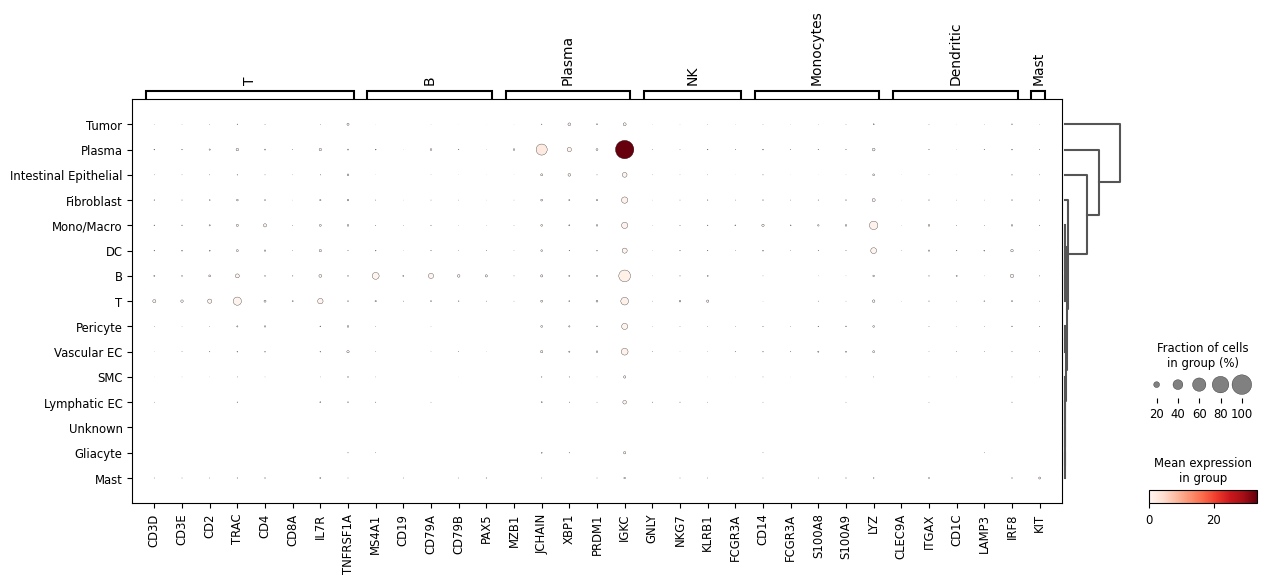

SVC processed data dotplot:
categories: B, DC, Fibroblast, etc.
var_group_labels: T, B, Plasma, etc.


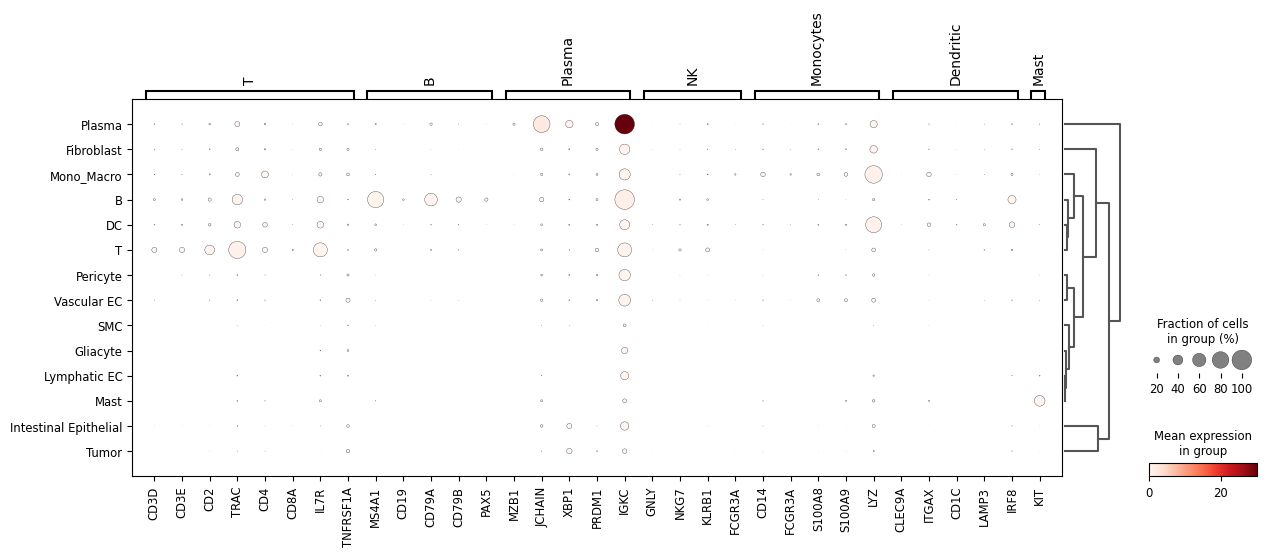

In [24]:
groupby = "Level1"
# 绘制两个adata的dotplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# 绘制原始数据的dotplot
sc.pl.dotplot(adata_sp, selected_marker_genes, groupby, 
              dendrogram=True, ax=ax1, show=False)
ax1.set_title(f'Raw Data - {patient_id}_{data_type}')

# 绘制SVC处理后数据的dotplot
sc.pl.dotplot(adata_sp_svc, selected_marker_genes, groupby, 
              dendrogram=True, ax=ax2, show=False)
ax2.set_title(f'SVC Processed Data - {patient_id}_{data_type}')

plt.tight_layout()
plt.show()

# 也可以分别绘制两个图
print("Raw data dotplot:")
sc.pl.dotplot(adata_sp, selected_marker_genes, groupby, dendrogram=True)

print("SVC processed data dotplot:")
sc.pl.dotplot(adata_sp_svc, selected_marker_genes, groupby, dendrogram=True)